In [4]:
import numpy as np
import sys
sys.path.append("..")
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys

from missing_process.block_rules import *
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from tqdm import tqdm


In [5]:
syn_datalist = ["syn1"]


#missingtypelist = ["quantile","diffuse","logistic"]
missingtypelist = ["diffuse"]

seed = 1
nfold = 5



In [6]:
def load_origin_data(missingtypelist,datalist_name):
    '''
    create density plot
    '''
    
    datalist = syn_datalist

    for missingtype in missingtypelist:
        if missingtype == "logistic":
            missing_rule = load_json_file("missing_rate.json")
        elif missingtype == "diffuse":
            missing_rule = load_json_file("diffuse_ratio.json")
        elif missingtype == "quantile":
            missing_rule = load_json_file("quantile_full.json")

        # load data and its mask
        for dataname in datalist:
            directory_path = f"../datasets/{dataname}"    
            norm_values = np.load(f'{directory_path}/{dataname}_norm.npy')
            
            print(dataname)


            for rule_name in missing_rule:
                observed_masks = np.load(f'{directory_path}/{missingtype}/{rule_name}.npy')


            return norm_values,observed_masks

In [7]:
def RMSE(mask,complete,imputed):
    missing_data_points = mask == 0

    # Extracting the originally missing data from both complete and imputed data
    original_values = complete[missing_data_points]
    imputed_values = imputed[missing_data_points]

    # Calculating RMSE
    rmse = np.sqrt(np.mean((original_values - imputed_values) ** 2))

    return rmse




def MAE(mask,complete,imputed):
    missing_data_points = mask == 0

    # Extracting the originally missing data from both complete and imputed data
    original_values = complete[missing_data_points]
    imputed_values = imputed[missing_data_points]

    # Calculating RMSE
    mae = np.mean(np.abs(original_values - imputed_values))

    return mae

In [8]:
def load_impute_data(missingtype,model_name,rule_name,dataname,fold,seed = 1):

    train_impute = np.load(f'../impute/{missingtype}/{dataname}/{model_name}/{rule_name}_seed-{seed}_{fold}_train.npy')
    test_impute = np.load(f'../impute/{missingtype}/{dataname}/{model_name}/{rule_name}_seed-{seed}_{fold}_test.npy')
    return train_impute,test_impute

def load_train_test(index_file,norm_values,observed_masks):  

    train_index = index_file["train_index"]
    test_index = index_file["test_index"]

    train_values = norm_values[train_index,:]

    train_masks = observed_masks[train_index,:]

    test_values = norm_values[test_index,:]

    test_masks = observed_masks[test_index,:]

    return train_values,train_masks,test_values,test_masks

In [13]:
dataname= "syn1"
missingtypelist = ["logistic"]
model_list = ["GAIN","knn","mean","mice","missforest","XGB",
            #"hyper"
            ]


directory_path = f"../datasets/{dataname}"  
for missingtype in missingtypelist:
    if missingtype == "logistic":
        missing_rule = load_json_file("missing_rate.json")
    elif missingtype == "diffuse":
        missing_rule = load_json_file("diffuse_ratio.json")
    elif missingtype == "quantile":
        missing_rule = load_json_file("quantile_full.json")

    train_rmse = {"normal":{},"categorical":{},"skewed":{},"bi-modal":{}}
    train_mae = {"normal":{},"categorical":{},"skewed":{},"bi-modal":{}}
    test_rmse = {"normal":{},"categorical":{},"skewed":{},"bi-modal":{}}
    test_mae = {"normal":{},"categorical":{},"skewed":{},"bi-modal":{}}

    for rule_name in tqdm(missing_rule):
        
        observed_masks = np.load(f'{directory_path}/{missingtype}/{rule_name}.npy')
        
        for model_name in model_list:
            train_rmse_list = []
            train_mae_list = []
            test_rmse_list = []
            test_mae_list = []

            for fold in index_file:
                index = index_file[fold]
                train_values,train_masks,test_values,test_masks = load_train_test(index,norm_values,observed_masks)
                impute_train,impute_test  = load_impute_data(missingtype,model_name,rule_name,dataname,fold)

                train_rmse = RMSE(train_masks,train_values,impute_train)
                train_mae = MAE(train_masks,train_values,impute_train)

                test_rmse = RMSE(test_masks,test_values,impute_test)
                test_mae = MAE(test_masks,test_values,impute_test)

                train_rmse_list.append(train_rmse)
                train_mae_list.append(train_mae)
                test_rmse_list.append(test_rmse)
                test_mae_list.append(test_mae)


100%|██████████| 9/9 [00:00<00:00, 1799.44it/s]

0.1 [True, True, True, True, True, True, True, True]
0.2 [True, True, True, True, True, True, True, True]
0.3 [True, True, True, True, True, True, True, True]
0.4 [True, True, True, True, True, True, True, True]
0.5 [True, True, True, True, True, True, True, True]
0.6 [True, True, True, True, True, True, True, True]
0.7 [True, True, True, True, True, True, True, True]
0.8 [True, True, True, True, True, True, True, True]
0.9 [True, True, True, True, True, True, True, True]


In [87]:
#datalist = real_datalist
dataname= "syn1"
modelist = ["GAIN","knn","mean","mice","missforest","XGB",
            "hyper","ot","miwae","notmiwae"
            ]
plot = False


directory_path = f"../datasets/{dataname}"    
norm_values = np.load(f'{directory_path}/{dataname}_norm.npy')
f = open(f'{directory_path}/split_index_cv_seed-{seed}_nfold-{nfold}.json')
index_file = json.load(f)

for missingtype in missingtypelist:
    if missingtype == "logistic":
        missing_rule = load_json_file("missing_rate.json")
    elif missingtype == "diffuse":
        missing_rule = load_json_file("diffuse_ratio.json")
    elif missingtype == "quantile":
        missing_rule = load_json_file("quantile_full.json")

    train_rmse_mean = None
    train_mae_mean = None

    test_rmse_mean = None
    test_mae_mean = None
    for rule_name in tqdm(missing_rule):
        
        
        observed_masks = np.load(f'{directory_path}/{missingtype}/{rule_name}.npy')

        model_rank_train_rmse = []
        model_rank_test_rmse = []
        model_rank_train_mae = []
        model_rank_test_mae = []

        for model_name in modelist:
            train_rmse_list = []
            train_mae_list = []
            test_rmse_list = []
            test_mae_list = []

            for fold in index_file:
                index = index_file[fold]
                train_values,train_masks,test_values,test_masks = load_train_test(index,norm_values,observed_masks)
                impute_train,impute_test  = load_impute_data(missingtype,model_name,rule_name,dataname,fold)

                train_rmse = RMSE_columnwise(train_masks,train_values,impute_train)
                train_mae = RMSE_columnwise(train_masks,train_values,impute_train)

                test_rmse = RMSE_columnwise(test_masks,test_values,impute_test)
                test_mae = RMSE_columnwise(test_masks,test_values,impute_test)

                train_rmse_list.append(train_rmse)
                train_mae_list.append(train_mae)
                test_rmse_list.append(test_rmse)
                test_mae_list.append(test_mae)
        
            

            model_rank_train_rmse.append(np.mean(train_rmse_list,axis=0))

            model_rank_train_mae.append(np.mean(train_mae_list,axis=0))

            model_rank_test_rmse.append(np.mean(test_rmse_list,axis=0))

            model_rank_test_mae.append(np.mean(test_mae_list,axis=0))
            

        train_rmse_mean = update_ranking(train_rmse_mean,model_rank_train_rmse)
        test_rmse_mean = update_ranking(test_rmse_mean,model_rank_test_rmse)
        train_mae_mean = update_ranking(train_mae_mean,model_rank_train_mae)
        test_mae_mean = update_ranking(test_mae_mean,model_rank_test_mae)
        


100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


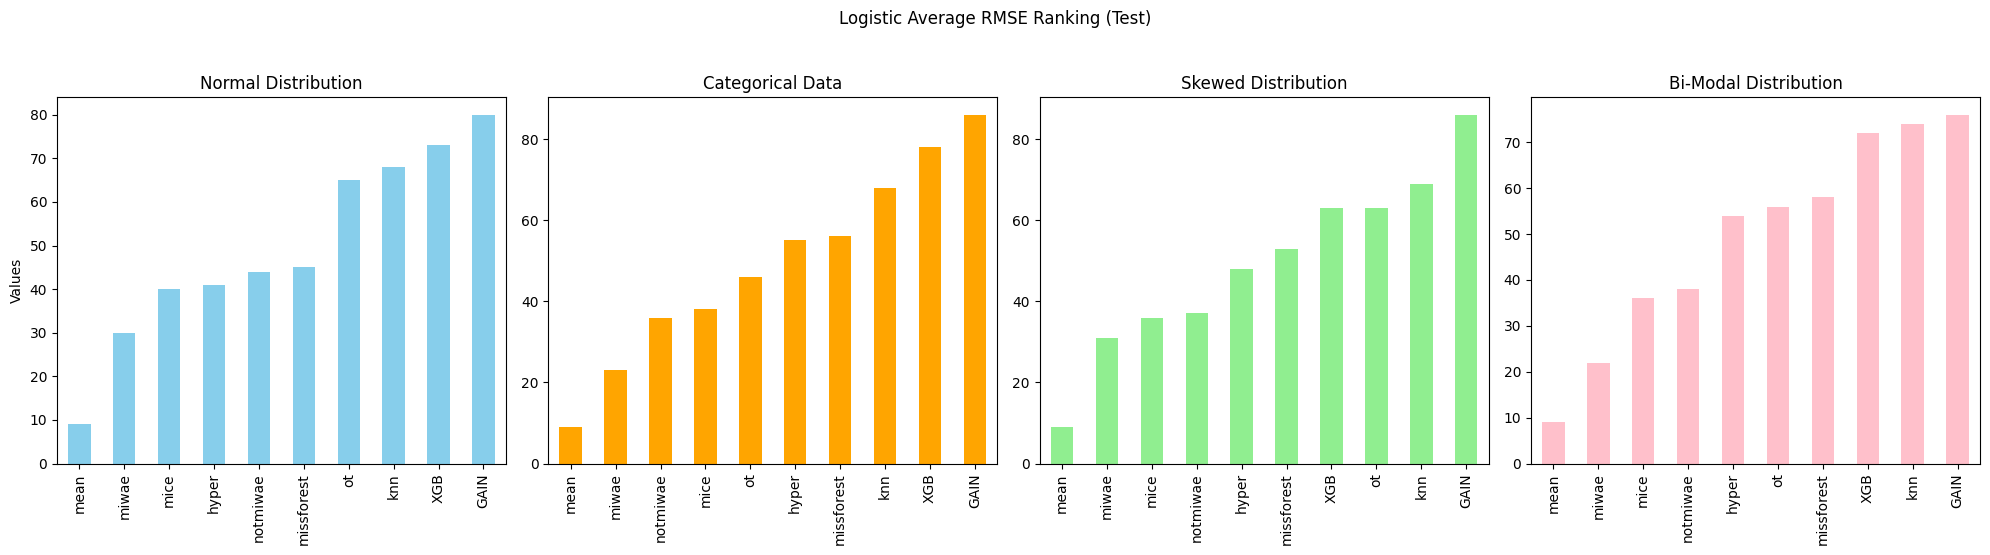

In [88]:

from sklearn.preprocessing import MinMaxScaler

# Plotting four bar charts
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

test_rmse_mean[0].sort_values().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Normal Distribution")
axes[0].set_ylabel("Values")

test_rmse_mean[1].sort_values().plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title("Categorical Data")

test_rmse_mean[2].sort_values().plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title("Skewed Distribution")

test_rmse_mean[3].sort_values().plot(kind='bar', ax=axes[3], color='pink')
axes[3].set_title("Bi-Modal Distribution")

plt.tight_layout()
fig.suptitle("Logistic Average RMSE Ranking (Test)",y = 1.1)
plt.savefig(f"../plot/{dataname}_{missingtype}_TestRMSE_Ranking.png")
plt.show()

In [60]:
def update_ranking(ranking_df,new_ranking):
    df = pd.DataFrame(np.array(new_ranking).T,columns=[model_name for model_name in modelist])
    averaged_df = df.groupby(df.index // 2).mean().reset_index(drop=True)

    new_rank_df = averaged_df.T.rank()

    if ranking_df is not None:

        ranking_df = new_rank_df + ranking_df
    else:
        ranking_df = new_rank_df

    return ranking_df


In [14]:
def RMSE_columnwise(mask, complete, imputed):


    # Initializing an array to store RMSE for each column
    rmse_per_column = np.zeros(complete.shape[1])

    # Iterate over each column
    for i in range(complete.shape[1]):
        missing_data_points = mask[:, i] == 0
        # Extracting the originally missing data from both complete and imputed data
        original_values = complete[missing_data_points, i]
        imputed_values = imputed[missing_data_points, i]

        # Calculating RMSE for this column
        rmse_per_column[i] = np.sqrt(np.mean((original_values - imputed_values) ** 2))

    return rmse_per_column


In [7]:
def make_plot(norm_value,impute,mask, title = None,subtitle = None):

    indices = np.argsort(subtitle)[-8:]

    # Sorting the indices and converting to a list
    sorted_indices = np.sort(indices).tolist()

        # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(12, 12))
    axes = axes.ravel()  # Flatten the 4x2 grid for easy iteration

    impute_value = impute
    nan_mask = np.where(mask == 0, np.nan, mask)
    masked_value_na = norm_value * nan_mask
    
    

    for i in range(len(sorted_indices)):
        norm_column = norm_value[:, sorted_indices[i]]
        impute_column = impute_value[:, sorted_indices[i]]
        mask_column_na = masked_value_na[:, sorted_indices[i]]

        
        bins = np.histogram_bin_edges([norm_column, impute_column], bins='auto')
        #data_column2 = array_list[1][i]
        # Histogram
        #axes[i].hist(data_column, bins=30, alpha=0.7, edgecolor='black',kde = True)
        sns.histplot(data=norm_column, bins=bins, color='orange',alpha = 0.4, ax=axes[i], kde=True, label='Complete Data',
                     #hatch="", 
                     fill=False
                     )
        sns.histplot(data=mask_column_na, bins=bins, color='blue',alpha = 0.1, ax=axes[i], kde=True, label='Observed Data',
                     #hatch="/", 
                     #fill=False
                     )
        sns.histplot(data=impute_column, bins=bins, color='green',alpha = 0.6, ax=axes[i], kde=True, label='Imputed Data',
                     hatch='...', 
                     fill=False
                     )
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        if subtitle[i]:
            axes[i].set_title(f'Histogram for Column {sorted_indices[i]+1} RMSE: {subtitle[i]}')
        else:
            axes[i].set_title(f'Histogram for Column {sorted_indices[i]+1}')
        axes[i].legend()

    if title is not None:
        fig.suptitle(title, fontsize=16)
        # Adjust the layout
    plt.tight_layout()
    plt.savefig(f"../plot/{title}.png")
    plt.show()